In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from statsmodels.tsa.api import VAR

np.random.seed(1995)

%matplotlib inline

In [2]:
A = np.array([[0.8, 0.7], [-0.2, 0.5]])
sigma = 0.9

def var_sample(T = 100):
    ''' Simula el VAR(1) T períodos'''
    X = np.zeros((T,2))
    for t in range(1, T):
        X[t] = X[t-1] @ A.T + sigma * np.random.randn(2)
    
    trimestres = pd.date_range(start='1992q1',freq='d',periods=T)
    return pd.DataFrame(X, columns=['precio', 'cantidad'],index=trimestres)

def A_ols(data):
    '''Estima un VAR(1) a partir de datos, retorna coeficientes como vector'''
    return VAR(data).fit().coefs[0].flatten()


def estimaciones_var(T=100):
    return A_ols(var_sample(T))


from joblib import Parallel, delayed

def Monte_Carlo(funcion, repeticiones, columnas, *args, **kwargs):
    """
    Ejecuta simulaciones de Montecarlo en paralelo, aprovechando todos los núcleos del procesador

    Argumentos:
        funcion: una función que dé por resultado una única realización de las cantidades que se desean simular
        repeticiones: un entero que indica cuántas muestras se desean simular
        columnas: una lista (o tupla) de strings, que identifiquen a las cantidades individuales retornadas por funcion
        *args, **kwargs: otros parámetros requeridos por funcion

    Retorna:
         Un data frame de pandas, con tantas filas como `repeticiones` y columnas como textos en `columnas`.
    """
    datos = Parallel(n_jobs=-1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
    return pd.DataFrame(datos, columns=columnas)

In [3]:
%%time
nrepetitions = 10000
estimates = Monte_Carlo(estimaciones_var, nrepetitions, ['$Φ_{11}$', '$Φ_{21}$', '$Φ_{12}$', '$Φ_{22}$'])

Wall time: 11.2 s


In [4]:
estimates.head()

,$Φ_{11}$,$Φ_{21}$,$Φ_{12}$,$Φ_{22}$
0,0.765712,0.819384,-0.156429,0.458297
1,0.739452,0.663542,-0.338397,0.381836
2,0.716336,0.727302,-0.139867,0.566685
3,0.884918,0.603639,-0.191849,0.483225
4,0.838614,0.785583,-0.193505,0.422932


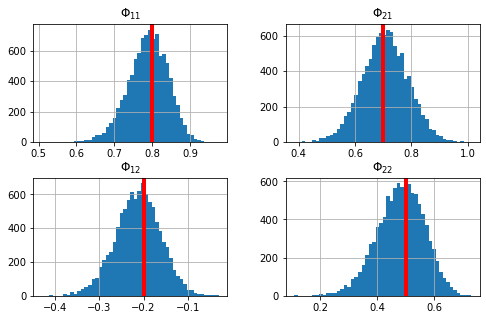

In [5]:
ax = estimates.hist(bins=50,figsize=[8,5])

for i in range(2):
    for j in range(2):
        ax[i,j].axvline(x=A[i,j],linewidth=4, color='r')
        
#plt.gcf().savefig('imag/var-insesgado.pdf',bbox_inches='tight')        

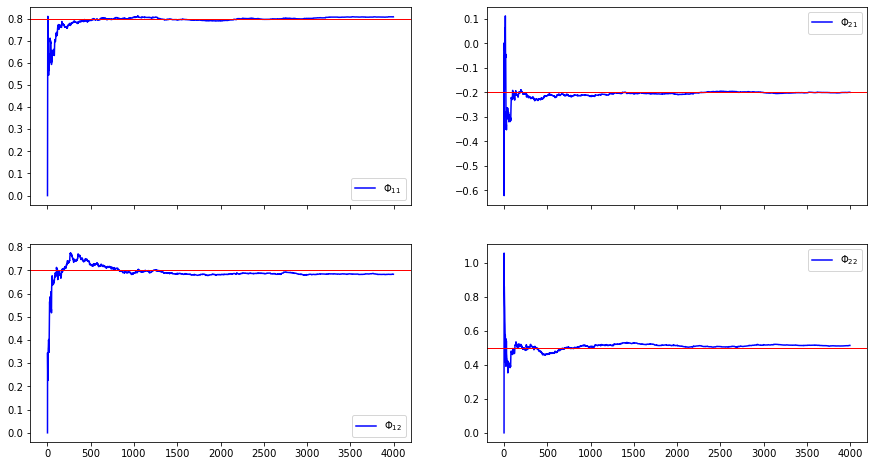

In [6]:
xlag = np.zeros([2,1])
XpX = np.zeros([2,2])
XpY = np.zeros([2,2])

T = 4000
minT = 4
Xest = np.zeros([T+1, 4])

for t in range(T+1):
    x = A @ xlag + sigma * np.random.randn(2,1)
    XpX += np.outer(xlag, xlag)
    XpY += np.outer(xlag, x)
    xlag = x.copy()
    
    if t>minT:
        Xest[t] = np.linalg.solve(XpX/t, XpY/t).flatten()
    
    
estimates2 = pd.DataFrame(Xest[minT:], columns=['$Φ_{11}$', '$Φ_{21}$', '$Φ_{12}$', '$Φ_{22}$'])

ax = estimates2.plot(color='b',figsize=[15,8],subplots=True, layout=[2,2])

for i in range(2):
    for j in range(2):
        ax[i,j].axhline(y=A[j,i],linewidth=1, color='r')

#plt.gcf().savefig('imag/var-consistente.pdf',bbox_inches='tight') 